# Titanic: Machine Learning from Disaster

## 簡世育 Allen CHien 

# Description of Data 

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

# Contents

- [Import Libraries and loading data](#Import-Libraries-and-loading-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Model training](#Model-training)

# Import Libraries and loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set( font_scale=1.5)
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
def missing_data(df):
    """遺失值總和、百分比"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum().div(df.isnull().count()).sort_values(ascending=False))
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submit = pd.read_csv('gender_submission.csv')

# Exploratory Data Analysis

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print('train_shape:', train.shape, 'test_shape:', test.shape)

train_shape: (891, 12) test_shape: (418, 11)


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Feature description

* Survived: 生存與否(0 = No, 1 = Yes) - int64

* Pclass: 艙等 (1 = 1st, 2 = 2nd, 3 = 3rd) - int64
* Name: 乘客名字 - object
* Sex: 性別 - object
* Age: 年紀 - float64
* SibSp:兄弟姊妹/配偶數量  - int  
* Parch:父母/小孩數量  - int
* Ticket: 票號 - string
* Fare: 票價 - float
* Cabin: 船艙編號  - string
* Embarked:  登船船口 - string


* **Numerical Variables:** Age , Fare , SibSp , Parch 
* **Categorical Variable:** Survived, Sex, Embarked, Pclass, Ticket, Cabin

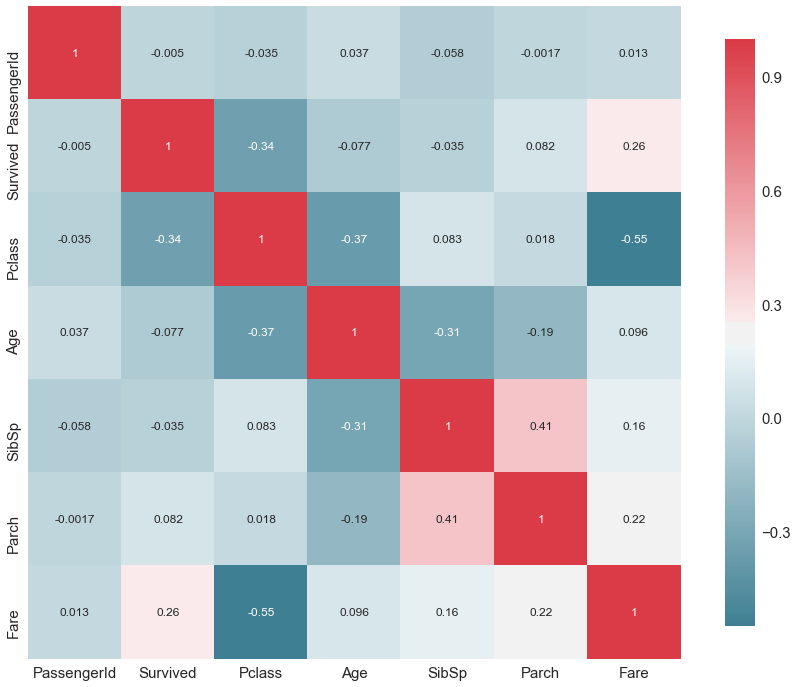

In [8]:
corr = train.corr()
_ , ax = plt.subplots(figsize=(16, 12))
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

### Sex

In [9]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

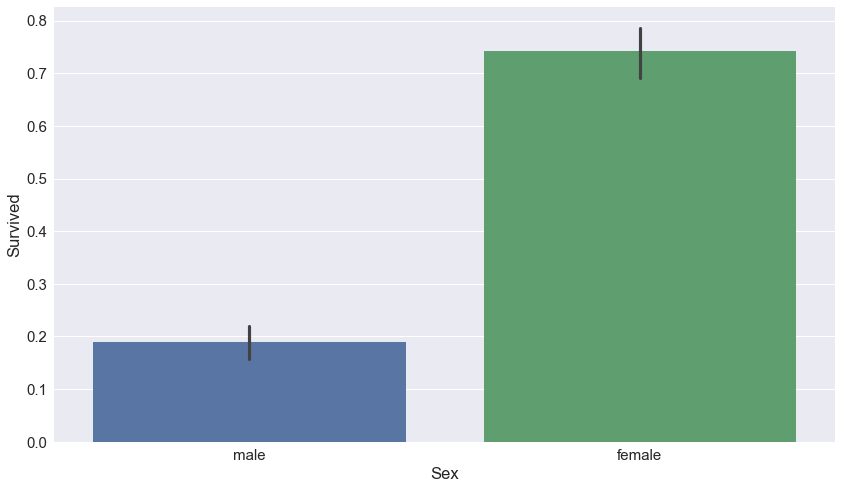

In [10]:
plt.subplots(figsize=(14, 8))
sns.barplot(x='Sex', y='Survived', data=train)
plt.show()

上圖可知**男性死亡率較女性高

In [11]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


### Pclass

In [12]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

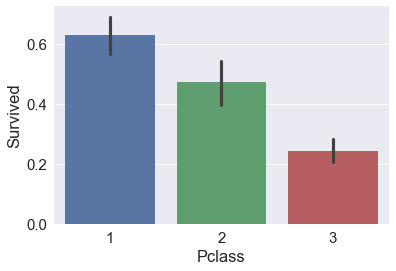

In [13]:
#draw a bar plot of survival by Pclass
sns.barplot(x="Pclass", y="Survived", data=train)
plt.show()

In [14]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


1st存活率:62.96%; 2nd存活率:47.28%; 3st存活率:24.23%

### SibSp

In [15]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

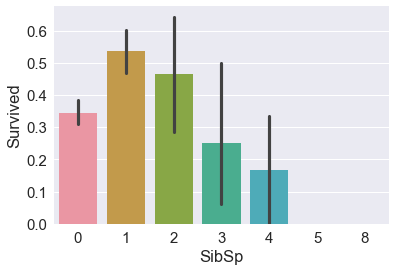

In [16]:
#draw a bar plot for SibSp vs. survival
sns.barplot(x="SibSp", y="Survived", data=train)
plt.show()

In [17]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


### Parch

In [18]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

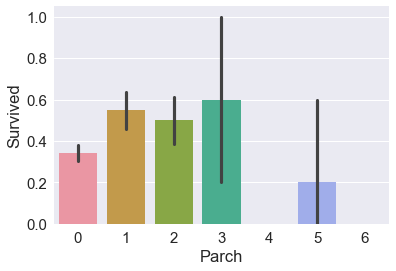

In [19]:
sns.barplot(x="Parch", y="Survived", data=train)
plt.show()

In [20]:
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


### Family Size

In [21]:
train4V = train.copy()

In [22]:
train4V['FamilySize'] = train4V['SibSp']+ train4V['Parch']

In [23]:
train4V['FamilySize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

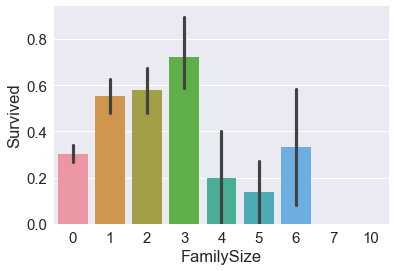

In [24]:
sns.barplot(x="FamilySize", y="Survived", data=train4V)
plt.show()

In [25]:
train4V[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.724138
4,4,0.200000
5,5,0.136364
6,6,0.333333
7,7,0.000000
8,10,0.000000


### Age

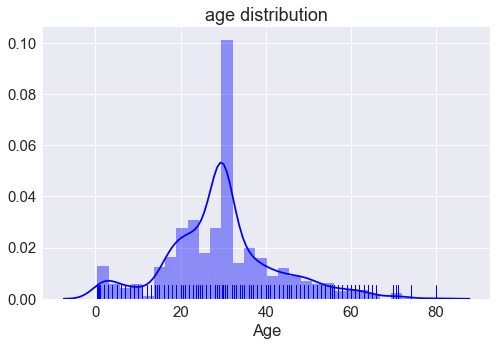

In [26]:
fig, ax = plt.subplots(1,figsize=(8,5))
sns.distplot(train.Age.fillna(np.mean(train.Age)), rug=True, color='b')
ax.set_title('age distribution')

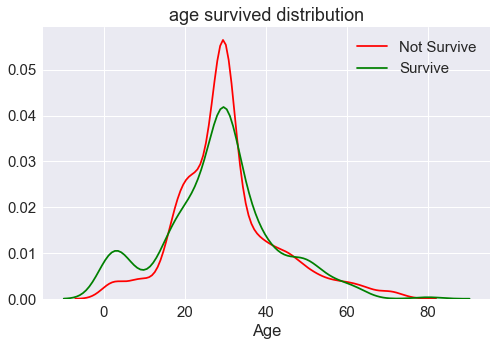

In [27]:
fig, axes = plt.subplots(1,figsize=(8,5))
axes.set_title('age survived distribution')
k1 = sns.distplot(train[train.Survived==0].Age.fillna(np.mean(train.Age)), hist=False, color='r', label='Not Survive')
k2 = sns.distplot(train[train.Survived==1].Age.fillna(np.mean(train.Age)), hist=False, color='g', label='Survive')

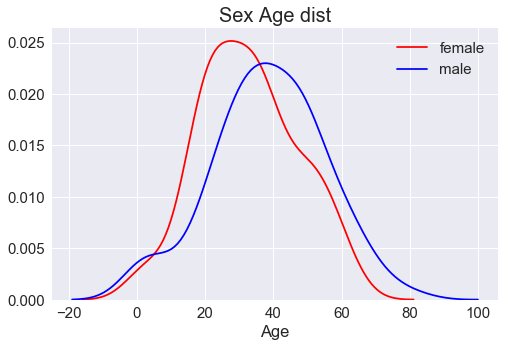

In [28]:
f, ax = plt.subplots(figsize=(8,5))
ax.set_title('Sex Age dist', size=20)
sns.distplot(train[train.Sex=='female'].dropna().Age, hist=False, color='R', label='female')
sns.distplot(train[train.Sex=='male'].dropna().Age, hist=False, color='B', label='male')
ax.legend(fontsize=15)

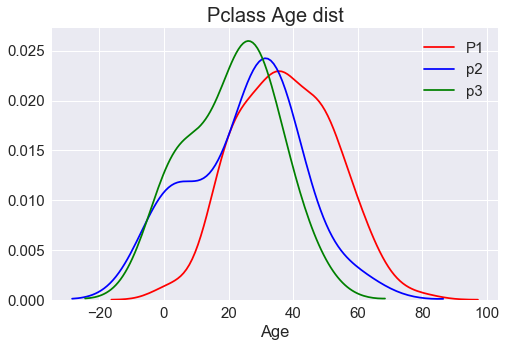

In [29]:
f, ax = plt.subplots(figsize=(8,5))
ax.set_title('Pclass Age dist', size=20)
sns.distplot(train[train.Pclass==1].dropna().Age, hist=False, color='r', label='P1')
sns.distplot(train[train.Pclass==2].dropna().Age, hist=False, color='b', label='p2')
sns.distplot(train[train.Pclass==3].dropna().Age, hist=False, color='g', label='p3')
ax.legend(fontsize=15)

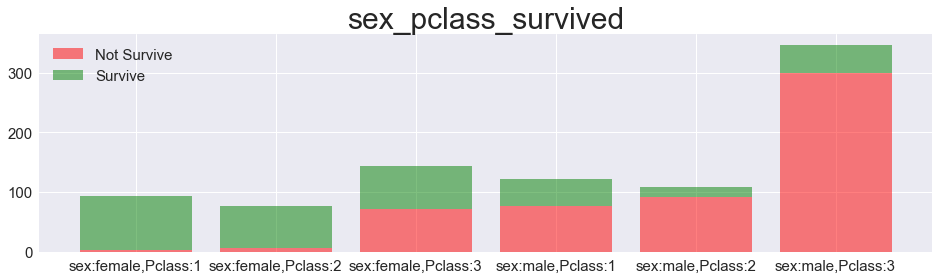

In [30]:
label = []
for sex_i in ['female','male']:
    for pclass_i in range(1,4):
        label.append('sex:%s,Pclass:%d'%(sex_i, pclass_i))
        
pos = range(6)
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.bar(pos, 
        train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values, 
        color='r', 
        alpha=0.5, 
        align='center',
        tick_label=label, 
        label='Not Survive')
ax.bar(pos, 
        train[train['Survived']==1].groupby(['Sex','Pclass'])['Survived'].count().values, 
        bottom=train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values,
        color='g',
        alpha=0.5,
        align='center',
        tick_label=label, 
        label='Survive')
ax.tick_params(labelsize=15)
ax.set_title('sex_pclass_survived', size=30)
ax.legend(fontsize=15,loc='best')

### Fare

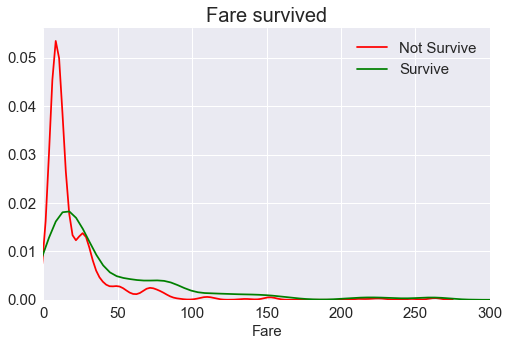

In [31]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
sns.kdeplot(train[train.Survived==0].Fare, ax=ax1, label='Not Survive', color='r')
sns.kdeplot(train[train.Survived==1].Fare, ax=ax1, label='Survive', color='g')
#sns.distplot(train[train.Survived==0].Fare, ax=ax1, color='r')
#sns.distplot(train[train.Survived==1].Fare, ax=ax1, color='g')
ax1.set_xlim([0,300])
ax1.legend(fontsize=15)
ax1.set_title('Fare survived', size=20)
ax1.set_xlabel('Fare', size=15)

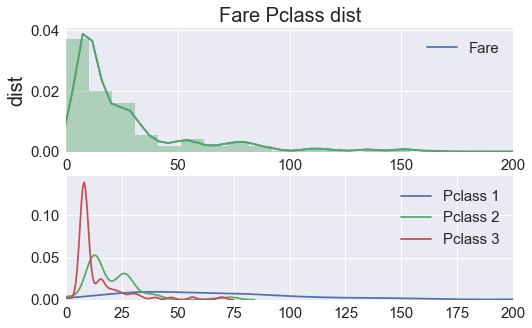

In [32]:
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)

ax.tick_params(labelsize=15)
ax.set_title('Fare dist', size=20)
ax.set_ylabel('dist', size=20)
sns.kdeplot(train.Fare, ax=ax)
sns.distplot(train.Fare, ax=ax)
ax.legend(fontsize=15)
pos = range(0,400,50)
ax.set_xticks(pos)
ax.set_xlim([0, 200])


ax1 = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.set_title('Fare Pclass dist', size=20)
for i in range(1,4):
    sns.kdeplot(train[train.Pclass==i].Fare, ax=ax1, label='Pclass %d'%(i))
ax1.set_xlim([0,200])
ax1.legend(fontsize=15)

### Embarked 

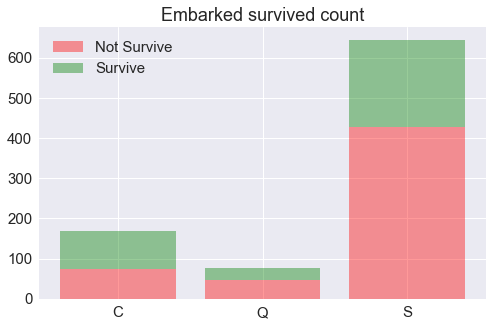

In [33]:
ax = plt.figure(figsize=(8,5)).add_subplot(111)
pos = [1, 2, 3]
y1 = train[train.Survived==0].groupby('Embarked')['Survived'].count().sort_index().values
y2 = train[train.Survived==1].groupby('Embarked')['Survived'].count().sort_index().values
ax.bar(pos, y1, color='r', alpha=0.4, align='center', label='Not Survive')
ax.bar(pos, y2, color='g', alpha=0.4, align='center', label='Survive', bottom=y1)
ax.set_xticks(pos)
ax.set_xticklabels(['C','Q','S'])
ax.legend(fontsize=15, loc='best')
ax.set_title('Embarked survived count', size=18)

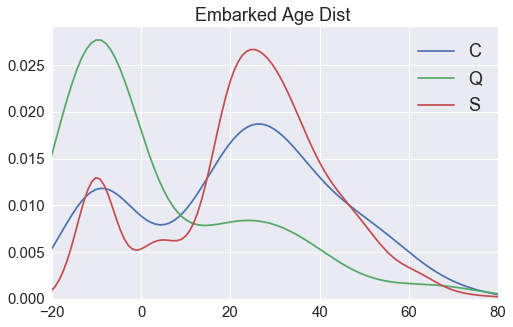

In [34]:
ax = plt.figure(figsize=(8,5)).add_subplot(111)
ax.set_xlim([-20, 80])
sns.kdeplot(train[train.Embarked=='C'].Age.fillna(-10), ax=ax, label='C')
sns.kdeplot(train[train.Embarked=='Q'].Age.fillna(-10), ax=ax, label='Q')
sns.kdeplot(train[train.Embarked=='S'].Age.fillna(-10), ax=ax, label='S')
ax.legend(fontsize=18)
ax.set_title('Embarked Age Dist ', size=18)

### Missing value

In [35]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [36]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Data Preprocessing

In [37]:
# combine train data and test data
total_df = pd.concat([train, test], axis = 0)

In [38]:
print('==========train==========')
print(missing_data(train).head())
print('==========test==========')
print(missing_data(test).head())
print('==========total==========')
print(missing_data(total_df).head())

==========train==========
          Total   Percent
Cabin       687  0.771044
Age         177  0.198653
Embarked      2  0.002245
Fare          0  0.000000
Ticket        0  0.000000
==========test==========
          Total   Percent
Cabin       327  0.782297
Age          86  0.205742
Fare          1  0.002392
Embarked      0  0.000000
Ticket        0  0.000000
==========total==========
          Total   Percent
Cabin      1014  0.774637
Survived    418  0.319328
Age         263  0.200917
Embarked      2  0.001528
Fare          1  0.000764


#### Embarked

In [39]:
total_df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [40]:
total_df['Embarked'].fillna('S',inplace=True)

#### Deal with Fare

In [41]:
total_df['Fare'].fillna(total_df['Fare'].mean(), inplace=True)

#### Deal with Cabin

In [42]:
total_df["Cabin"] = total_df['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin')#曲第一個字元

In [43]:
total_df["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

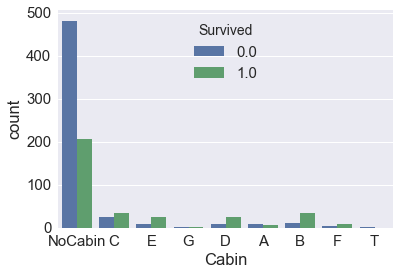

In [44]:
sns.countplot(total_df['Cabin'], hue=total_df['Survived'])

#### age

In [45]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestRegressor#處理age遺失值

C:\Users\hahohy889\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [46]:
#轉one-hot-encoding
total_df['Sex'] = total_df['Sex'].astype('category').cat.codes
total_df['Embarked'] = total_df['Embarked'].astype('category').cat.codes
total_df['Pclass'] = total_df['Pclass'].astype('category').cat.codes
total_df['Cabin'] = total_df['Cabin'].astype('category').cat.codes

In [47]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [48]:
dataAgeNull = total_df[total_df["Age"].isnull()]

In [49]:
dataAgeNotNull = total_df[total_df["Age"].notnull()]
dataAgeNotNull.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,7,2,7.2500,"Braund, Mr. Owen Harris",0,1,2,1,1,0.0,A/5 21171
1,38.0,2,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,0,1,1.0,PC 17599
2,26.0,7,2,7.9250,"Heikkinen, Miss. Laina",0,3,2,0,0,1.0,STON/O2. 3101282
3,35.0,2,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,0,1,1.0,113803
4,35.0,7,2,8.0500,"Allen, Mr. William Henry",0,5,2,1,0,0.0,373450


In [50]:
taAgeNull = total_df[total_df["Age"].isnull()]
dataAgeNotNull = total_df[total_df["Age"].notnull()]

FR_age = RandomForestRegressor(n_estimators=2000, random_state = 889)
ageX = ['Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
FR_age.fit(dataAgeNotNull[ageX], dataAgeNotNull['Age'])

age_predict = FR_age.predict(dataAgeNull[ageX])
dataAgeNull.loc[:,"Age"] = age_predict
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace=True, drop=True)

In [51]:
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

In [52]:
dataTrain.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
263,22.0,7,2,7.2500,"Braund, Mr. Owen Harris",0,1,2,1,1,0.0,A/5 21171
264,38.0,2,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,0,1,1.0,PC 17599
265,26.0,7,2,7.9250,"Heikkinen, Miss. Laina",0,3,2,0,0,1.0,STON/O2. 3101282
266,35.0,2,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,0,1,1.0,113803
267,35.0,7,2,8.0500,"Allen, Mr. William Henry",0,5,2,1,0,0.0,373450


In [53]:
dataTest.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
977,34.5,7,1,7.8292,"Kelly, Mr. James",0,892,2,1,0,NaN,330911
978,47.0,7,2,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,2,0,1,NaN,363272
979,62.0,7,1,9.6875,"Myles, Mr. Thomas Francis",0,894,1,1,0,NaN,240276
980,27.0,7,2,8.6625,"Wirz, Mr. Albert",0,895,2,1,0,NaN,315154
981,22.0,7,2,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,2,0,1,NaN,3101298


In [54]:
df_Train = dataTrain[['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived']]
df_test = dataTest[['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']]

# Model training

In [55]:
X = df_Train.iloc[:,:-1].values
y = df_Train.iloc[:,8].values
vaild = df_test.values

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

In [57]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=889)

In [58]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=2000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=889,
                             n_jobs=-1) 

rf.fit(train_X, train_y)
print("%.4f" % rf.oob_score_)

0.8026


In [59]:
pd.concat((pd.DataFrame(df_Train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
6,SibSp,0.308092
3,Parch,0.193362
0,Cabin,0.192021
5,Sex,0.098954
1,Embarked,0.089456
7,Survived,0.048903
4,Pclass,0.035913
2,Fare,0.033299


In [60]:
import xgboost as xgb
from xgboost import XGBClassifier
xgbr = xgb.XGBClassifier(n_estimators = 3000,  
                            min_child_weight = 3, 
                            gamma = 0, 
                            colsample_bytree = 0.7, 
                            reg_alpha = 1, 
                            reg_lambda = 0.01, 
                            learning_rate = 0.01,
                            random_state = 889)
xgbr.fit(train_X, train_y)
print("%.4f" % xgbr.score(train_X, train_y))

0.8844


In [61]:
xgbr_res =  xgbr.predict(vaild)

In [62]:
real_value = submit['Survived']

In [63]:
accuracy_score(xgbr_res, real_value)

0.8636363636363636

In [64]:
submit['Survived'] = xgbr_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit.csv', index= False)

In [65]:
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
